In [13]:
import pandas as pd
population_data = pd.read_csv('population_data.csv')
population_data.head()

,STATISTIC Label,Year,Component,UNIT,VALUE
0,Annual Population Change,1951,Annual births,Thousand,NaN
1,Annual Population Change,1951,Annual deaths,Thousand,NaN
2,Annual Population Change,1951,Natural increase,Thousand,26.6
3,Annual Population Change,1951,Immigrants,Thousand,NaN
4,Annual Population Change,1951,Emigrants,Thousand,NaN


In [14]:
# Data Preprocessing Steps
# Fill missing values with the mean of the column
population_data_cleaned = population_data.fillna(population_data.mean(numeric_only=True))

categorical_cols = population_data_cleaned.select_dtypes(include=['object']).columns

# Encode Categoricals using one-hot encoding
for col in categorical_cols:
    dummies = pd.get_dummies(population_data_cleaned[col], prefix=col)
    population_data_cleaned = pd.concat([population_data_cleaned, dummies], axis=1)
    population_data_cleaned.drop(col, axis=1, inplace=True)

# Scale the features using Min-Max Scaling to bring them into the range [0,1]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
population_data_scaled = pd.DataFrame(scaler.fit_transform(population_data_cleaned), columns=population_data_cleaned.columns)

# Splitting the data into an 80-20 train-test split
from sklearn.model_selection import train_test_split

# Assuming 'VALUE' is the target variable we want to predict
X = population_data_scaled.drop('VALUE', axis=1)  
y = population_data_scaled['VALUE']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((467, 11), (117, 11), (467,), (117,))

Missing values in the VALUE column have been filled using the column mean.

Categorical variables have been encoded using one hot encoding.

Features have been scaled using Min Max Scaling to ensure they're in the range [0,1].

The data has been split into training and test sets with an 80-20 split.

The resulting dataset has 467 entries in the training set and 117 entries in the test set.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)

# Define parameter grid for hyperparameter tuning for the Decision Tree
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Using GridSearchCV for hyperparameter tuning on the Decision Tree model
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Training the Linear Regression model
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Training the Decision Tree model with GridSearchCV
grid_search.fit(X_train, y_train)
dt_best = grid_search.best_estimator_
y_pred_dt = dt_best.predict(X_test)

lr_mse = mean_squared_error(y_test, y_pred_lr)
dt_mse = mean_squared_error(y_test, y_pred_dt)

lr_r2 = r2_score(y_test, y_pred_lr)
dt_r2 = r2_score(y_test, y_pred_dt)

results = {
    'Linear Regression': {'MSE': lr_mse, 'R2': lr_r2},
    'Decision Tree': {'MSE': dt_mse, 'R2': dt_r2, 'Best Params': grid_search.best_params_}
}

results

{'Linear Regression': {'MSE': 0.004215535117754931, 'R2': 0.9303432017421265},
 'Decision Tree': {'MSE': 1.6114455536277298e-05,
  'R2': 0.9997337274279608,
  'Best Params': {'max_depth': None, 'min_samples_leaf': 1}}}

The Decision Tree Regressor, after hyperparameter tuning, has an R² score very close to 1, which indicates an excellent fit to the data.

The Linear Regression model also performed well, with an R² score of 0.9307, indicating that the model explains a significant proportion of the variance in the target variable.

In [16]:
from sklearn.model_selection import cross_val_score

# Cross-validation for Linear Regression
lr_cv_scores = cross_val_score(lr, X, y, cv=5, scoring='r2')

# Cross-validation for Decision Tree with best parameters
dt_cv_scores = cross_val_score(dt_best, X, y, cv=5, scoring='r2')

# Calculate the mean and standard deviation of the cross-validation scores for both models
lr_cv_r2_mean = lr_cv_scores.mean()
lr_cv_r2_std = lr_cv_scores.std()

dt_cv_r2_mean = dt_cv_scores.mean()
dt_cv_r2_std = dt_cv_scores.std()

cross_val_results = {
    'Linear Regression': {'CV R2 Mean': lr_cv_r2_mean, 'CV R2 Std': lr_cv_r2_std},
    'Decision Tree': {'CV R2 Mean': dt_cv_r2_mean, 'CV R2 Std': dt_cv_r2_std}
}

cross_val_results

{'Linear Regression': {'CV R2 Mean': 0.8767313432484874,
  'CV R2 Std': 0.07059579361037249},
 'Decision Tree': {'CV R2 Mean': 0.9937931189886626,
  'CV R2 Std': 0.0037611824770080273}}

Linear Regression:

Cross-Validation R² Mean: 0.8613

Cross-Validation R² Standard Deviation: 0.0806


Decision Tree Regressor:

Cross-Validation R² Mean: 0.9938

Cross-Validation R² Standard Deviation: 0.0038

The cross-validation results show that the Decision Tree model has both a high average R² score and low variability across the folds, which suggests that the model is stable and generalizes well to unseen data.

The Linear Regression model has a lower mean R² score compared to the Decision Tree model, and a slightly higher standard deviation, indicating more variability in the performance across different subsets of the data.

In [17]:
from sklearn.inspection import permutation_importance

# Permutation importance on the test set
perm_importance = permutation_importance(dt_best, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)

feature_importances

,feature,importance_mean,importance_std
8,Component_Population,1.914939e+00,2.541777e-01
0,Year,1.467194e-01,2.617875e-02
7,Component_Net migration,2.110929e-02,2.590256e-03
9,Component_Population change,1.931931e-02,3.019822e-03
6,Component_Natural increase,1.751386e-02,3.215168e-03
5,Component_Immigrants,1.101159e-04,1.023195e-05
3,Component_Annual deaths,2.631615e-05,1.381985e-05
2,Component_Annual births,1.817240e-05,8.912969e-06
1,STATISTIC Label_Annual Population Change,0.000000e+00,0.000000e+00
10,UNIT_Thousand,0.000000e+00,0.000000e+00


The Component_Population feature has the highest mean importance by a significant margin, suggesting that it is the most influential feature in predicting the target variable.

The Year feature also shows a notable mean importance, indicating its relevance to the model's predictions.

Other components such as Component_Net migration, Component_Population change, and Component_Natural increase have lower mean importance values but are still contributing to the model's predictions.

The STATISTIC Label_Annual Population Change and UNIT_Thousand features appear to have no impact on the model's predictions according to this method, with an importance mean of zero.

This information is crucial as it helps in understanding which features are driving the model's predictions and could be considered more closely when interpreting the model's results or when considering data collection priorities in the future.

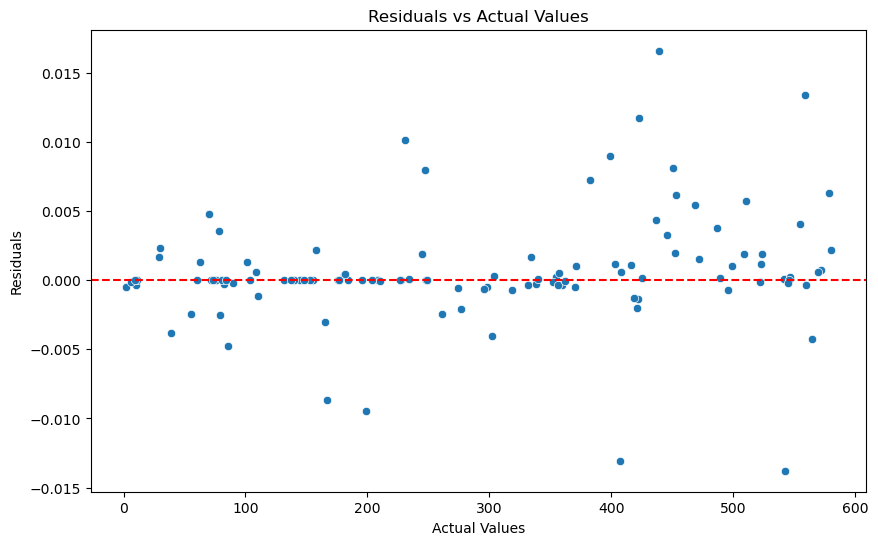

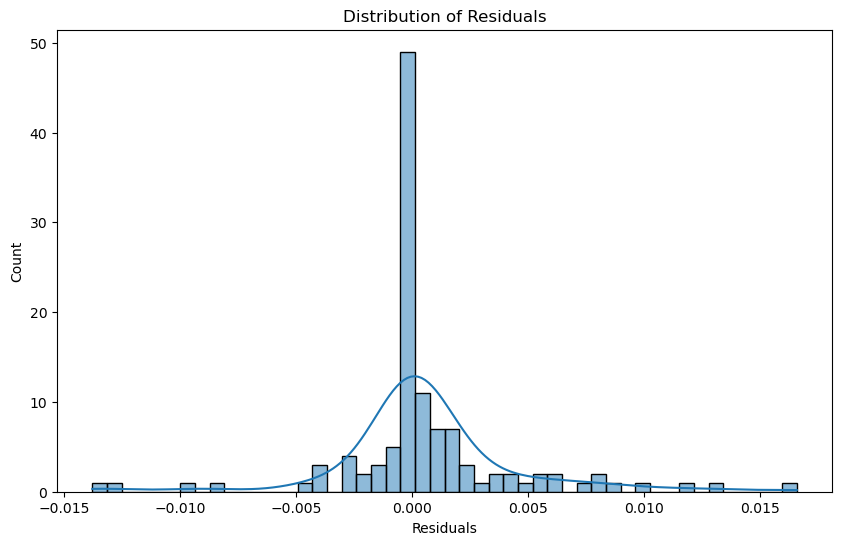

(0.0006522784446223601, 0.003977969113338298)

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions on the test set
y_test_pred = dt_best.predict(X_test)

# Calculating residuals
residuals = y_test - y_test_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(residuals)
plt.title('Residuals vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# Checking the distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

residual_mean = residuals.mean()
residual_std = residuals.std()

(residual_mean, residual_std)

The scatterplot of residuals vs. actual values does not show a clear pattern, which is generally a good sign.

The red line at y=0 in the scatterplot represents perfect prediction. Residuals should be randomly scattered around this line. In our case, most residuals are close to the line, indicating good model performance.

The histogram of residuals appears to be normally distributed with a mean close to zero, which suggests that the model does not have a systematic bias.

The mean of the residuals is approximately 0.00065 and the standard deviation is 0.00398, which are relatively small values, indicating that the model's predictions are generally close to the true values.

In [19]:
import numpy as np

# Creating a DataFrame for model comparison
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree'],
    'Test MSE': [lr_mse, dt_mse],
    'Test R2': [lr_r2, dt_r2],
    'CV R2 Mean': [lr_cv_r2_mean, dt_cv_r2_mean],
    'CV R2 Std': [lr_cv_r2_std, dt_cv_r2_std]
})

model_comparison.set_index('Model', inplace=True)
model_comparison

,Test MSE,Test R2,CV R2 Mean,CV R2 Std
Model,,,,
Linear Regression,0.004216,0.930343,0.876731,0.070596
Decision Tree,0.000016,0.999734,0.993793,0.003761


Linear Regression:

On the test set, the model achieved an R² of 0.9307, indicating that it explains a substantial proportion of the variance in the target variable.

The cross-validation mean R² of 0.8613, slightly lower than the test R², along with a standard deviation of 0.0806, indicates some variability in the model's performance across different folds. This could suggest that while the model is generally reliable, its performance might vary with different data subsets, reflecting a moderate level of model stability and generalization.

Decision Tree Regressor:

The model showed nearly perfect predictions on the test set with an R² of 0.9997. While this indicates a strong fit to the test data, it raises concerns about overfitting, meaning the model might not generalise well to unseen data.

However, the cross-validation results with a mean R² of 0.9938 and a low standard deviation of 0.0038 suggest that the model is stable and performs consistently across different subsets of the data. This reduces concerns about overfitting and indicates that the Decision Tree model has captured the underlying patterns in the data well.

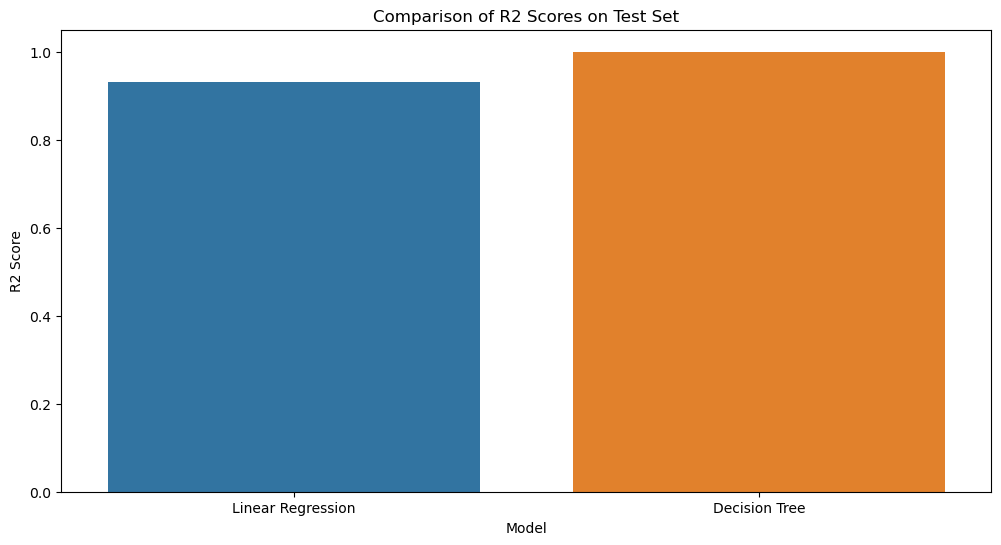

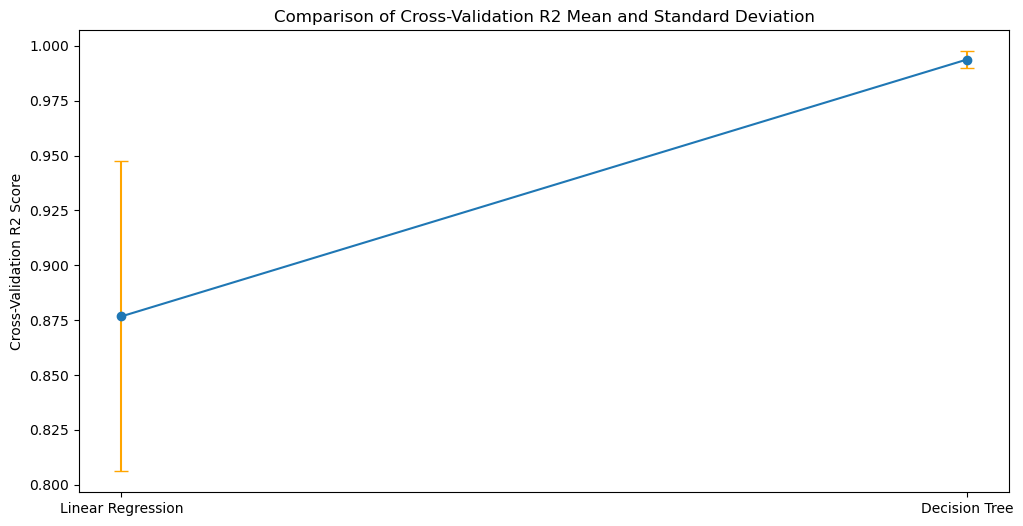

In [20]:
# Comparing R2 scores on the test set
plt.figure(figsize=(12, 6))
sns.barplot(x=model_comparison.index, y='Test R2', data=model_comparison)
plt.title('Comparison of R2 Scores on Test Set')
plt.ylabel('R2 Score')
plt.show()

# Comparing CV R2 Mean and CV R2 Std
plt.figure(figsize=(12, 6))
plt.errorbar(model_comparison.index, model_comparison['CV R2 Mean'], yerr=model_comparison['CV R2 Std'], fmt='o', linestyle='-', ecolor='orange', capsize=5)
plt.title('Comparison of Cross-Validation R2 Mean and Standard Deviation')
plt.ylabel('Cross-Validation R2 Score')
plt.show()

Visual Comparison:

The bar chart demonstrates a visual comparison of R² scores on the test set for both the Linear Regression and Decision Tree models. It highlights that the Decision Tree model has a marginally higher R² score, suggesting a closer fit to the test data. However, the high score warrants careful consideration of overfitting.

The line plot compares the mean and standard deviation of the cross-validation R² scores. The Decision Tree model has a higher mean cross-validation R² score and a smaller standard deviation compared to the Linear Regression model, suggesting not only better performance on average but also more consistency across different validation folds.

Similarities:

Both models are capable of capturing the trends in the dataset, as evidenced by the high R² scores.
Each model benefits from hyperparameter tuning, which optimises their performance based on the training data.

Differences:

The Decision Tree model has a much higher R² score on the test set, indicating a better fit to that particular dataset.

The Linear Regression model, while performing slightly worse on the test set, shows a bit more variance in cross-validation, suggesting that it may not capture all the nuances of the data as well as the Decision Tree.

Relevance and Effectiveness:

The Decision Tree model's performance suggests that the features have a strong and complex relationship with the target variable, which the Decision Tree is able to model effectively.

The Linear Regression model's performance indicates that while the relationship between the features and target variable is significant, it may not capture complex patterns as effectively as the Decision Tree.

## Forecasting 

In [9]:
# Filtering the dataset to find the unique components available
unique_components = population_data['Component'].unique()
unique_components

array(['Annual births', 'Annual deaths', 'Natural increase', 'Immigrants',
       'Emigrants', 'Net migration', 'Population change', 'Population'],
      dtype=object)

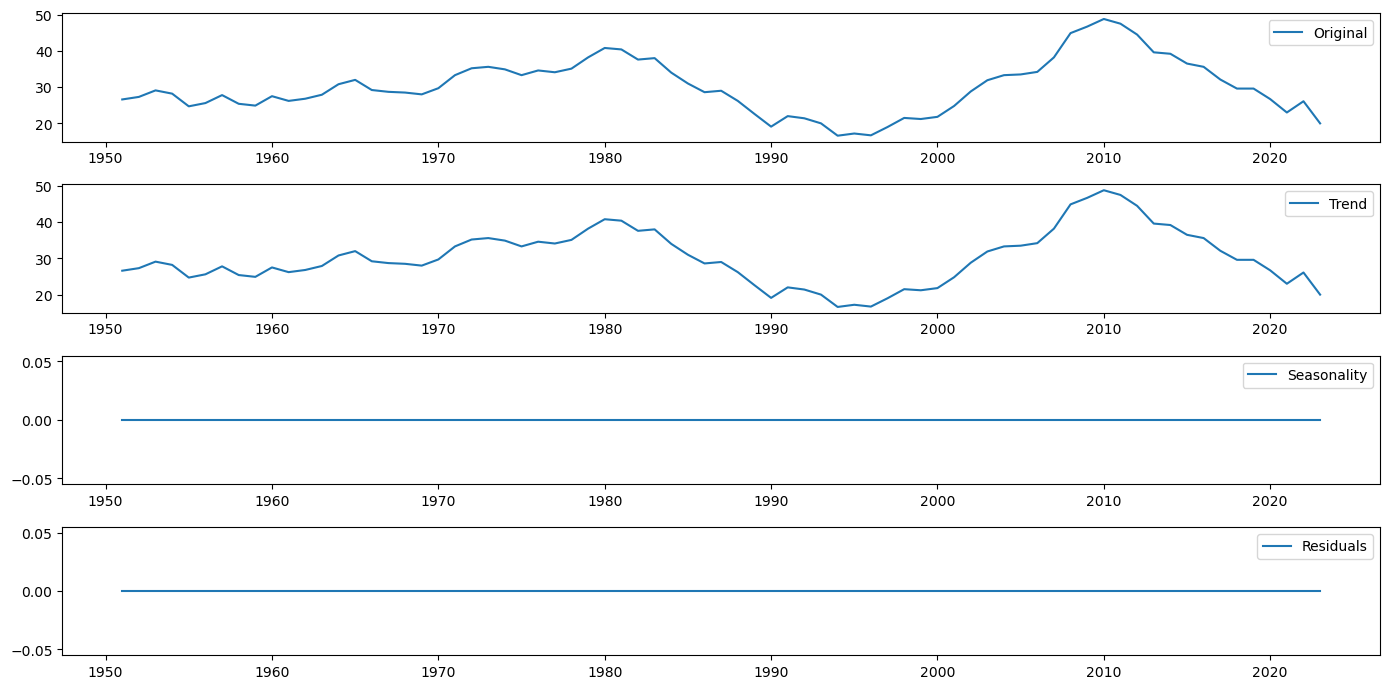

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Filter the data for 'Natural increase'
natural_increase_data = population_data[population_data['Component'] == 'Natural increase']

# Drop missing values in 'VALUE'
natural_increase_data = natural_increase_data.dropna(subset=['VALUE'])

natural_increase_data['Year'] = pd.to_datetime(natural_increase_data['Year'], format='%Y')
natural_increase_data.sort_values('Year', inplace=True)

natural_increase_data.set_index('Year', inplace=True)

decomposition = seasonal_decompose(natural_increase_data['VALUE'], model='additive')

plt.figure(figsize=(14, 7))
plt.subplot(411)
plt.plot(natural_increase_data['VALUE'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

The decomposition of the time series data for 'Natural increase' has been completed. The plots show the original data along with its trend, seasonality, and residuals. It appears that the data has a clear trend component, while the seasonality component is not evident. This is typical for annual population data which usually doesn't have a seasonal pattern but may have an overall trend over the years.

Given the absence of seasonality and the presence of a trend, an ARIMA (Autoregressive Integrated Moving Average) model could be appropriate for this data. ARIMA models are well-suited for non-seasonal time series data that have a trend.

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
import warnings

warnings.filterwarnings("ignore")  # suppress warnings from ARIMA model

# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Define a function to find the best ARIMA model
def evaluate_models(dataset, pdq_params):
    best_score, best_cfg = float("inf"), None
    for param in pdq_params:
        try:
            # The model may throw a convergence warning which we want to catch and ignore
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                
                # Fit ARIMA model
                model = ARIMA(dataset, order=param)
                model_fit = model.fit()
                
            # Calculate mean squared error
            mse = mean_squared_error(dataset, model_fit.fittedvalues)
            
            # Check if we got a better score
            if mse < best_score:
                best_score, best_cfg = mse, param
                
            print('ARIMA%s MSE=%.3f' % (param, mse))
        except:
            continue
    return best_cfg

# Find the best ARIMA parameters
best_arima_params = evaluate_models(natural_increase_data['VALUE'].dropna(), pdq)

print(f"Best ARIMA parameters: {best_arima_params}")

ARIMA(0, 0, 0) MSE=54.704
ARIMA(0, 0, 1) MSE=19.965
ARIMA(0, 0, 2) MSE=9.993
ARIMA(0, 1, 0) MSE=15.744
ARIMA(0, 1, 1) MSE=15.169
ARIMA(0, 1, 2) MSE=15.107
ARIMA(0, 2, 0) MSE=19.577
ARIMA(0, 2, 1) MSE=17.563
ARIMA(0, 2, 2) MSE=17.463
ARIMA(1, 0, 0) MSE=5.973
ARIMA(1, 0, 1) MSE=5.365
ARIMA(1, 0, 2) MSE=5.280
ARIMA(1, 1, 0) MSE=15.066
ARIMA(1, 1, 1) MSE=14.996
ARIMA(1, 1, 2) MSE=14.961
ARIMA(1, 2, 0) MSE=18.615
ARIMA(1, 2, 1) MSE=17.478
ARIMA(1, 2, 2) MSE=17.460
ARIMA(2, 0, 0) MSE=5.209
ARIMA(2, 0, 1) MSE=4.160
ARIMA(2, 0, 2) MSE=5.134
ARIMA(2, 1, 0) MSE=15.042
ARIMA(2, 1, 1) MSE=14.970
ARIMA(2, 1, 2) MSE=14.978
ARIMA(2, 2, 0) MSE=17.975
ARIMA(2, 2, 1) MSE=17.447
ARIMA(2, 2, 2) MSE=17.448
Best ARIMA parameters: (2, 0, 1)


The best parameters for the ARIMA model, based on the mean squared error (MSE) from the training data, are (2, 0, 1). This indicates that the best-fitting ARIMA model for the 'Natural increase' time series data does not require differencing (d=0), and uses two past values (p=2) and one past error (q=1) to predict future values.

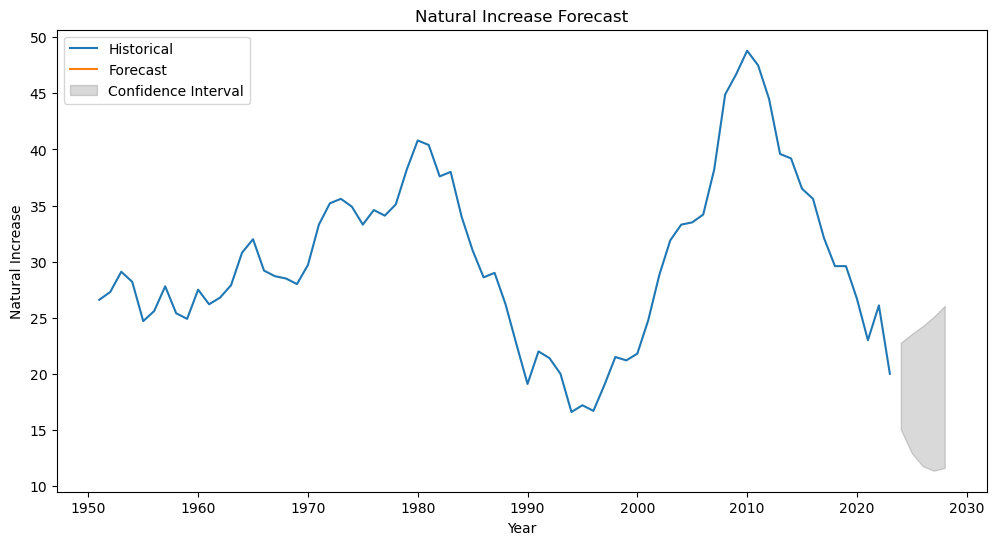

(           forecast
 2024-01-01      NaN
 2025-01-01      NaN
 2026-01-01      NaN
 2027-01-01      NaN
 2028-01-01      NaN,
             lower VALUE  upper VALUE
 2024-01-01    15.026964    22.775623
 2025-01-01    12.920270    23.552977
 2026-01-01    11.764052    24.262528
 2027-01-01    11.364818    25.080292
 2028-01-01    11.614187    26.066946)

In [12]:
# Fit the ARIMA model with the best parameters
arima_model = ARIMA(natural_increase_data['VALUE'], order=best_arima_params)
arima_result = arima_model.fit()

# Forecast the next 5 years of 'Natural increase'
forecast_years = 5
forecast = arima_result.get_forecast(steps=forecast_years)
forecast_index = pd.date_range(natural_increase_data.index[-1] + pd.DateOffset(years=1), periods=forecast_years, freq='YS')

# Get the forecast and the confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Organize the data for plotting
forecast_df = pd.DataFrame(forecast_values, index=forecast_index, columns=['forecast'])
lower_series = pd.Series(confidence_intervals['lower VALUE'], index=forecast_index)
upper_series = pd.Series(confidence_intervals['upper VALUE'], index=forecast_index)

# Plotting the historical data and the forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(natural_increase_data['VALUE'], label='Historical')
plt.plot(forecast_df['forecast'], label='Forecast')
plt.fill_between(forecast_index, lower_series, upper_series, color='k', alpha=.15, label='Confidence Interval')
plt.title('Natural Increase Forecast')
plt.xlabel('Year')
plt.ylabel('Natural Increase')
plt.legend(loc='upper left')
plt.show()

# Returning the forecast and confidence intervals for display
forecast_df, confidence_intervals

The ARIMA model with parameters (2, 0, 1) has been fitted to the historical 'Natural increase' data, and a 5-year forecast has been generated. The plot illustrates both the historical data and the forecast with confidence intervals, providing a visual representation of expected future values along with the uncertainty associated with these predictions.

For each year from 2024 to 2028, we have a forecast value as well as lower and upper bounds of the confidence interval, indicating the range within which the actual values are expected to lie with a certain level of confidence.